In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import re
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import warnings
import matplotlib.pyplot as plt
from razdel import tokenize as razdel_tokenize


warnings.filterwarnings('ignore')

df = pd.read_csv('Petitions.csv')
df = df[['public_petition_text', 'reason_category']].dropna()
df = df[:10000]
print(f"Исходный размер датасета: {df.shape}")

Исходный размер датасета: (10000, 2)


In [10]:
display(df.head(20))

,public_petition_text,reason_category
0,снег на дороге,Благоустройство
1,очистить кабельный киоск от рекламы,Благоустройство
2,"Просим убрать все деревья и кустарники, которы...",Благоустройство
3,Неудовлетворительное состояние парадной - надп...,Содержание МКД
4,Граффити,Благоустройство
5,Необходимо проверить законность установки выве...,Незаконная информационная и (или) рекламная ко...
6,"Уборка не производится, на лестнице очень гряз...",Содержание МКД
7,Мусор,Благоустройство
8,Отсутствует освещение на лестничной площадке м...,Содержание МКД
9,"Зачем было делать благоустройство, если никто ...",Благоустройство


In [11]:
print(df['reason_category'].unique())

['Благоустройство' 'Содержание МКД'
 'Незаконная информационная и (или) рекламная конструкция' 'Фасад'
 'Водоснабжение' 'Нарушение правил пользования общим имуществом'
 'Повреждения или неисправность элементов уличной инфраструктуры' 'Кровля'
 'Состояние рекламных или информационных конструкций'
 'Нарушение порядка пользования общим имуществом' 'Подвалы'
 'Водоотведение' 'Санитарное состояние' 'Центральное отопление'
 'Незаконная реализация товаров с торгового оборудования (прилавок, ящик, с земли)']


---

Размер словаря: 3000
Средняя длина: 30.7
Медиана: 17.0
Максимальная: 578
Минимальная: 3


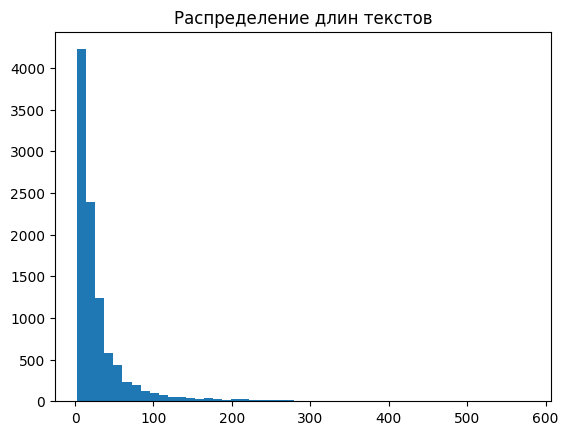

\1
Оригинал: снег на дороге...
Очищенный: снег на дороге
Токены: ['[CLS]', 'с', '##не', '##г', 'на', 'дороге', '[SEP]']
Длина: 7
\2
Оригинал: очистить кабельный киоск от рекламы...
Очищенный: очистить кабельный киоск от рекламы
Токены: ['[CLS]', 'о', '##чи', '##сти', '##ть', 'каб', '##ель', '##ный', 'ки', '##ос', '##к', 'от', 'рек', '##лам', '##ы', '[SEP]']
Длина: 16
\3
Оригинал: Просим убрать все деревья и кустарники, которые вышли за пределы газона на пешеходную зону, начиная ...
Очищенный: просим убрать все деревья и кустарники которые вышли за пределы газона на пешеходную зону начиная от подъезда 13 до подъезда 15 фасад дома со стороны ул наличной
Токены: ['[CLS]', 'про', '##си', '##м', 'у', '##брать', 'все', 'дерев', '##ья', 'и', 'к', '##ус', '##тар', '##ники', 'которые', 'вышли', 'за', 'пред', '##елы', 'газ', '##она', 'на', 'п', '##еше', '##ход', '##ную', 'зону', 'начиная', 'от', 'под', '##ъезда', '13', 'до', 'под', '##ъезда', '15', 'ф', '##аса', '##д', 'дома', 'со', 'стороны', '

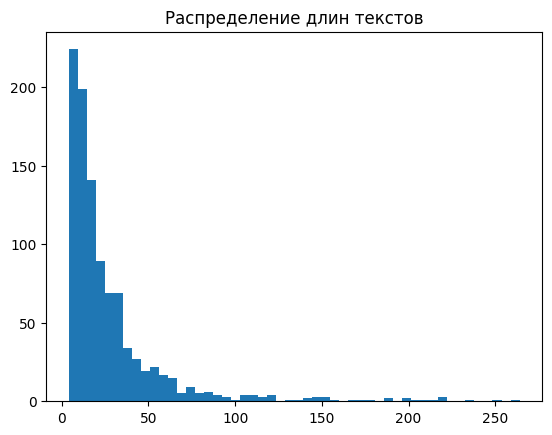

In [12]:
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tokenizers import Tokenizer
from sklearn.preprocessing import LabelEncoder

class TextPreprocessor:
    def __init__(self):
        self.tokenizer = Tokenizer.from_pretrained("bert-base-multilingual-cased")

    def analyze_text_lengths(self, texts):
        lengths = []
        for text in texts:
            cleaned = self.clean_text(text)
            tokens = self.tokenize(cleaned)
            lengths.append(len(tokens))
        
        print(f"Средняя длина: {np.mean(lengths):.1f}")
        print(f"Медиана: {np.median(lengths):.1f}")
        print(f"Максимальная: {np.max(lengths)}")
        print(f"Минимальная: {np.min(lengths)}")
        
        # Визуализация
        plt.hist(lengths, bins=50)
        plt.title('Распределение длин текстов')
        plt.show()
        
        return lengths

    def debug_token_samples(self, texts, n_samples=5):
        for i in range(min(n_samples, len(texts))):
            print(f"\{i+1}")
            print("Оригинал:", texts[i][:100] + "...")
            cleaned = self.clean_text(texts[i])
            print("Очищенный:", cleaned)
            tokens = self.tokenize(cleaned)
            print("Токены:", tokens)
            print("Длина:", len(tokens))

    def clean_text(self, text):
        text = str(text).lower()
        text = re.sub(r'[^а-яё0-9\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def tokenize(self, text):
        # Токенизация с помощью tokenizers: возвращает список токенов
        tokens = self.tokenizer.encode(text).tokens
        return tokens
    
    def build_vocab(self, texts, max_vocab_size=3000):
        all_tokens = []
        for text in texts:
            cleaned_text = self.clean_text(text)
            tokens = self.tokenize(cleaned_text)
            all_tokens.extend(tokens)
        
        word_counts = Counter(all_tokens)
        most_common = word_counts.most_common(max_vocab_size)
        self.vocab = {word: idx+1 for idx, (word, count) in enumerate(most_common)}
        self.vocab_size = len(self.vocab)
        print(f"Размер словаря: {self.vocab_size}")
        return self.vocab

    def text_to_sequence(self, text, max_length=100):
        #sequence - числовое представление текста, где каждое слово заменено на его индекс в словаре
        #короткие тексты заполняются нулями
        cleaned_text = self.clean_text(text)
        tokens = self.tokenize(cleaned_text)
        sequence = [self.vocab.get(token, 0) for token in tokens[:max_length]]
        
        if len(sequence) < max_length:
            sequence.extend([0] * (max_length - len(sequence)))
        return sequence

# Инициализация и построение словаря
preprocessor = TextPreprocessor()
all_texts = df['public_petition_text'].tolist()
vocab = preprocessor.build_vocab((all_texts), max_vocab_size=3000)

a = preprocessor.analyze_text_lengths(all_texts)
a = preprocessor.debug_token_samples(all_texts, 20)

# Кодируем целевой признак
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['reason_category'])
num_classes = len(label_encoder.classes_)

print(f"\nКлассы для классификации: {list(label_encoder.classes_)}")
print(f"Количество классов: {num_classes}")
lengths = preprocessor.analyze_text_lengths(all_texts[:1000])

---

In [13]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, preprocessor, max_length=50):
        self.texts = texts
        self.labels = labels
        self.preprocessor = preprocessor
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx] # Берет текст по индексу
        label = self.labels[idx] # Берет метку по индексу
        sequence = self.preprocessor.text_to_sequence(text, self.max_length) # Преобразует в числа
        return torch.tensor(sequence, dtype=torch.long), torch.tensor(label, dtype=torch.long)  # Возвращает признаки и метку как тензоры PyTorch

# Разделение данных
texts = df['public_petition_text'].tolist()
labels = df['category_encoded'].tolist()

X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.1, random_state=42, stratify=labels
)

print(f"\nРазмеры выборок:")
print(f"Обучающая: {len(X_train)}")
print(f"Тестовая: {len(X_test)}")

# Создание датасетов
train_dataset = TextDataset(X_train, y_train, preprocessor)
test_dataset = TextDataset(X_test, y_test, preprocessor)

# Создание WeightedRandomSampler для балансировки
# weight_class_i = total_samples / (n_classes * count_class_i)
class_weights = compute_class_weight( 
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

print(f"\nВеса классов: {class_weights}")

# Балансировка классов
sample_weights = class_weights[y_train]
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True # внутри WeightedRandomSampler берутся примеры классов, так мы разрешаем брать один и тот же пример
)

batch_size = 32 #512
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    sampler=sampler,
    shuffle=False  # Не shuffle когда используем sampler, т.к. логика выборки уже определяется семплером
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Размеры выборок:
Обучающая: 9000
Тестовая: 1000

Веса классов: [ 0.11406844 13.33333333  4.95867769  5.26315789 15.38461538  1.82370821
  2.15053763 16.66666667  3.37078652 17.64705882  8.95522388  0.28195489
  6.          2.62008734 14.63414634]


---

In [17]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, rnn_type='rnn'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.dropout = nn.Dropout(dropout)
        
        if rnn_type == 'rnn':
            self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, 
                             batch_first=True, dropout=dropout if n_layers > 1 else 0)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                              batch_first=True, dropout=dropout if n_layers > 1 else 0)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, n_layers, 
                             batch_first=True, dropout=dropout if n_layers > 1 else 0)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, lengths=None):
        embedded = self.embedding(x)
        
        rnn_out, hidden = self.rnn(embedded)
        
        if lengths is not None:
            rnn_out, _ = nn.utils.rnn.pad_packed_sequence(rnn_out, batch_first=True)
        
        # Умное извлечение последнего состояния
        if isinstance(self.rnn, nn.LSTM):
            hidden_state = hidden[0]
        else:
            hidden_state = hidden
        
        last_output = hidden_state[-1]
        
        return self.fc(self.dropout(last_output)) # Возвращаем логиты

---

In [50]:
def evaluate_model(model, test_loader):
    # Отключаем всё ненужное для оценки модели (градиент, dropout и т.д.)
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:             # Идём по батчам
            output = model(data)                     # получаем логиты от модели
            pred = output.argmax(dim=1)              # берем индекс максимального логита
            correct += (pred == target).sum().item() # считаем сколько верно, и преобразуем в число
            total += target.size(0)                  # добавляем размер батчей
    
    return correct / total

def train_model(model, train_loader, test_loader, epochs=10, lr=0.001):
    # 1. Взвешенная кросс-энтропия для борьбы с дисбалансом
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    
    # 2. Оптимизатор с настройками для лучшей сходимости
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # 3. Планировщик для адаптивного обучения
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,epochs=epochs,steps_per_epoch=len(train_loader))
    
    train_losses = []
    test_accuracies = []
    best_accuracy = 0
    patience_counter = 0
    patience = 5  # Ранняя остановка
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total_samples = 0
        
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data) # берём логиты
            loss = criterion(output, target)
            loss.backward()
            
            # Gradient clipping для стабильности
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
            
            # Считаем accuracy на тренировочной выборке
            pred = output.argmax(dim=1) # берём логиты
            correct += (pred == target).sum().item()
            total_samples += target.size(0)
        
        avg_loss = total_loss / len(train_loader)
        train_accuracy = correct / total_samples
        train_losses.append(avg_loss)
        
        # Оценка на тестовой выборке
        test_accuracy = evaluate_model(model, test_loader)
        test_accuracies.append(test_accuracy)
        
        # Ранняя остановка по accuracy
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            patience_counter = 0
            # Сохраняем лучшую модель
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 0.5
        
        if epoch % 2 == 0 or epoch == epochs - 1:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch:2d}: Loss: {avg_loss:.4f}, Train Acc: {train_accuracy:.4f}, 'f'Test Acc: {test_accuracy:.4f}, LR: {current_lr:.6f}')
        
        # Ранняя остановка
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            #break
    
    # Загружаем лучшую модель
    model.load_state_dict(torch.load('best_model.pth'))
    return train_losses, test_accuracies

---

In [26]:
vocab_size = preprocessor.vocab_size + 1
embedding_dim = 256
hidden_dim = 128
output_dim = num_classes
n_layers = 3
dropout = 0.3
epochs = 50

print(f"\nПараметры моделей:")
print(f"Vocab size: {vocab_size}, Embedding dim: {embedding_dim}, Hidden dim: {hidden_dim}")
print(f"Output dim: {output_dim}, Epochs: {epochs}")

print("Обучение RNN модели")
rnn_model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, 'rnn')
rnn_losses, rnn_accuracies = train_model(rnn_model, train_loader, test_loader, epochs)

print()
print("Обучение LSTM модели")
print()
lstm_model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, 'lstm')
lstm_losses, lstm_accuracies = train_model(lstm_model, train_loader, test_loader, epochs)

print()
print("Обучение GRU модели")
print()
gru_model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, 'gru')
gru_losses, gru_accuracies = train_model(gru_model, train_loader, test_loader, epochs)


Параметры моделей:
Vocab size: 3001, Embedding dim: 256, Hidden dim: 128
Output dim: 15, Epochs: 50
Обучение RNN модели
Epoch  0: Loss: 2.5185, Train Acc: 0.0781, Test Acc: 0.0040, LR: 0.000050
Epoch  2: Loss: 2.1940, Train Acc: 0.1463, Test Acc: 0.0050, LR: 0.000132
Epoch  4: Loss: 1.5964, Train Acc: 0.2552, Test Acc: 0.0070, LR: 0.000280
Epoch  6: Loss: 1.0439, Train Acc: 0.3866, Test Acc: 0.0110, LR: 0.000470
Epoch  8: Loss: 0.6255, Train Acc: 0.5289, Test Acc: 0.0240, LR: 0.000669
Epoch 10: Loss: 0.4343, Train Acc: 0.6106, Test Acc: 0.0290, LR: 0.000841
Epoch 12: Loss: 0.3652, Train Acc: 0.6507, Test Acc: 0.0520, LR: 0.000959
Epoch 14: Loss: 0.2997, Train Acc: 0.6996, Test Acc: 0.0670, LR: 0.001000
Epoch 16: Loss: 0.2531, Train Acc: 0.7382, Test Acc: 0.0640, LR: 0.000992
Epoch 18: Loss: 0.1923, Train Acc: 0.7608, Test Acc: 0.0740, LR: 0.000968
Epoch 20: Loss: 0.1752, Train Acc: 0.7882, Test Acc: 0.0730, LR: 0.000929
Epoch 22: Loss: 0.1412, Train Acc: 0.8054, Test Acc: 0.0800, LR: 

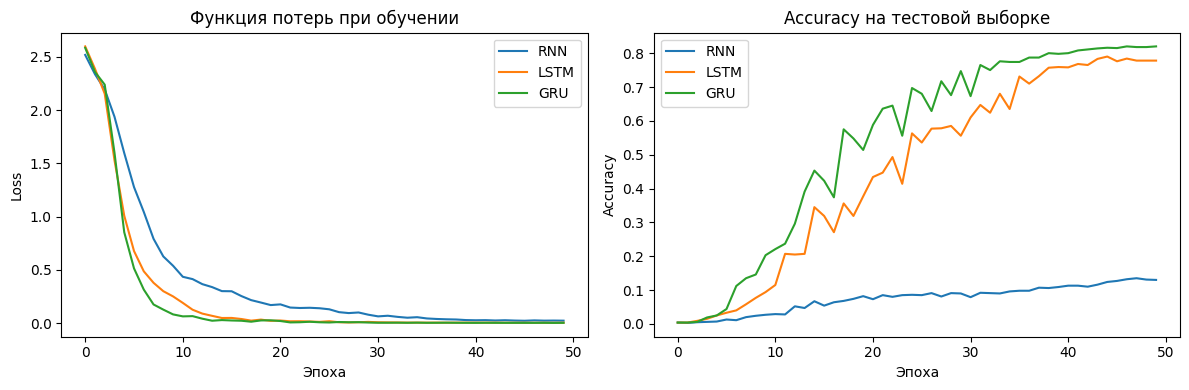

In [27]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(rnn_losses, label='RNN')
plt.plot(lstm_losses, label='LSTM')
plt.plot(gru_losses, label='GRU')
plt.title('Функция потерь при обучении')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rnn_accuracies, label='RNN')
plt.plot(lstm_accuracies, label='LSTM')
plt.plot(gru_accuracies, label='GRU')
plt.title('Accuracy на тестовой выборке')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

---

![GRU](GRU.jpg)

In [12]:
class MyGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, batch_first=True):
        super().__init__()
        self.batch_first = batch_first
        self.hidden_size = hidden_size
        
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            layer_input = input_size if i == 0 else hidden_size
            self.layers.append(nn.ModuleDict({
                'W': nn.Linear(layer_input, 3 * hidden_size),
                'U': nn.Linear(hidden_size, 3 * hidden_size, bias=False)
            }))
            # Создаём общую матрицу, потом разбиваем её на три штуки (Wz Wr W)
        
    def forward(self, x, h_0=None):
        if self.batch_first:
            x = x.transpose(0, 1)
        
        seq_len, batch_size, _ = x.shape
        num_layers = len(self.layers)
        
        if h_0 is None:
            h_0 = torch.zeros(num_layers, batch_size, self.hidden_size) # инициализируем вектор скрытого состояния
        
        output = x
        hidden_states = []
        
        for layer_idx, layer in enumerate(self.layers):
            h = h_0[layer_idx]
            layer_output = []
            
            for t in range(seq_len):
                gates = layer['W'](output[t]) + layer['U'](h) # создаём ворота (венитили)
                r, z, n = gates.chunk(3, 1)                   # разбиваем матрицу на Wz Wr W
                
                r, z = r.sigmoid(), z.sigmoid()               # добавляем функции аквивации
                n = torch.tanh(n)
                
                h = z * h + (1 - z) * n                       # добавляем изменения в вектор скрытого состояния
                layer_output.append(h)                        # добавляем h в выход слоя (h, потому что потом другой слой посчитает y)
            
            output = torch.stack(layer_output)
            hidden_states.append(h)
        
        if self.batch_first:
            output = output.transpose(0, 1)
            
        return output, torch.stack(hidden_states)

class CustomGRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = MyGRU(embed_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.gru(embedded)
        return self.fc(self.dropout(hidden[-1]))

In [14]:
print("Проверка своей GRU модели")

# Используем старые параметры
cust_gru_model = CustomGRUClassifier(
    vocab_size=vocab_size, 
    embed_dim=embedding_dim, 
    hidden_dim=hidden_dim, 
    output_dim=output_dim, 
    n_layers=n_layers, 
    dropout=dropout
)

print("Обучение GRU модели")
cust_gru_losses, cust_gru_accuracies = train_model(cust_gru_model, train_loader, test_loader, epochs=30) 
# умеьшил кол-во эпох по сравнению с nn GRU, т.к. обучение идёт дольше чем у оригинальных моделей

Проверка своей GRU модели
Обучение GRU модели
Epoch  0: Loss: 2.5051, Train Acc: 0.0738, Test Acc: 0.0050, LR: 0.000069
Epoch  2: Loss: 1.1292, Train Acc: 0.3702, Test Acc: 0.0300, LR: 0.000280
Epoch  4: Loss: 0.3176, Train Acc: 0.7042, Test Acc: 0.1090, LR: 0.000604
Epoch  6: Loss: 0.1385, Train Acc: 0.8192, Test Acc: 0.1190, LR: 0.000888
Epoch  8: Loss: 0.0535, Train Acc: 0.8679, Test Acc: 0.2100, LR: 0.001000
Epoch 10: Loss: 0.0245, Train Acc: 0.9030, Test Acc: 0.2950, LR: 0.000978
Epoch 12: Loss: 0.0125, Train Acc: 0.9214, Test Acc: 0.4230, LR: 0.000913
Epoch 14: Loss: 0.0129, Train Acc: 0.9362, Test Acc: 0.4260, LR: 0.000812
Epoch 16: Loss: 0.0088, Train Acc: 0.9461, Test Acc: 0.5350, LR: 0.000682
Epoch 18: Loss: 0.0067, Train Acc: 0.9532, Test Acc: 0.5660, LR: 0.000537
Epoch 20: Loss: 0.0039, Train Acc: 0.9628, Test Acc: 0.6080, LR: 0.000388
Epoch 22: Loss: 0.0036, Train Acc: 0.9702, Test Acc: 0.6670, LR: 0.000250
Epoch 24: Loss: 0.0029, Train Acc: 0.9764, Test Acc: 0.7200, LR: 0

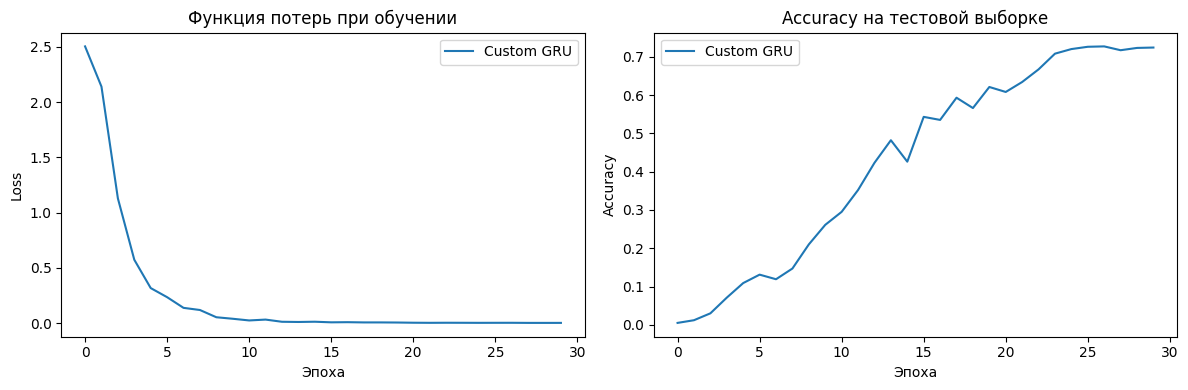

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(cust_gru_losses, label='Custom GRU')
plt.title('Функция потерь при обучении')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cust_gru_accuracies, label='Custom GRU')
plt.title('Accuracy на тестовой выборке')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
torch.save(rnn_model.state_dict(), 'rnn_model.pth')
torch.save(lstm_model.state_dict(), 'lstm_model.pth')
torch.save(gru_model.state_dict(), 'gru_model.pth')
torch.save(cust_gru_model.state_dict(), 'cust_gru_model.pth')
print("Модели сохранены в файлы")

In [49]:
# Сравнение всех моделей на одном тексте
test_text = "Пропала табличка с номером дома"
text_tensor = torch.tensor([preprocessor.text_to_sequence(test_text)])

print(f"Текст: '{test_text}'\n")

models = {'RNN': rnn_model, 'LSTM': lstm_model, 'GRU': gru_model}

for name, model in models.items():
    model.eval()
    with torch.no_grad():
        output = model(text_tensor)
        pred_class = output.argmax(dim=1).item()
        class_name = label_encoder.inverse_transform([pred_class])[0]
        prob = torch.softmax(output, dim=1)[0][pred_class].item()
    
    print(f"{name}: {class_name} (вероятность: {prob:.3f})")

Текст: 'Пропала табличка с номером дома'

RNN: Повреждения или неисправность элементов уличной инфраструктуры (вероятность: 0.953)
LSTM: Фасад (вероятность: 0.987)
GRU: Благоустройство (вероятность: 0.989)


Итог: 
* Модели модели LSTM и GRU часто выделяют верную тему обращения, но очень уверены в неправильных результатах.
* RNN демонстрирует низкое качество обучения
* Своя реализация GRU показывает хороший результат обучения, но обучается в 3 раза дольше, чем другие модели.
* Выявлено влияние размера батчей на результат обучения моделей. При размере батча 32 модели LSTM и GRU обучаются хорошо, а модель RNN практически не обучается. В случае выбора размера 512 результат обратный. Это может быть связанно с тем, что модель RNN имеет проблему исчезающих градиентов, а при таком размере батчей их вычисление происходит очень часто, что приводит к таким результатам, а модели LSTM и GRU решают эту проблему через вентили. Плохой результат LSTM и GRU при больших батчей можно объяснить тем, что большой батч может приводить к переобучению на ранних стадиях.
* Заметно, что LSTM даёт результаты чуть худше чем GRU, хотя GRU - упрощённая версия LSTM, это может быть связанно с тем, что LSTM сложнее и соответсвенно хуже обобщает, а данные, которые были предоставленны моделям, сокращены.